In [1]:
#!python setup.py build_ext --inplace

In [2]:
import numpy as np
import bayesflow as bf
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from simulator import retest2_imp as sim_v2

2023-05-17 13:25:43.911182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 13:25:44.013022: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-17 13:25:44.016006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 13:25:44.016019: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
import random 
random.seed(123)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
n_trials=20
v=-3
zr=0.5
a=30
ndt=0.8
alpha=1.7
dt=0.005
max_steps=10000
sv=0
szr=0
sndt=0

In [6]:
! python setup.py build_ext --inplace


running build_ext


In [7]:
def draw_prior():
    """Generates random draws from the prior."""
    v1 =np.random.uniform(low=0.0,high=6.0)
    v2 =np.random.uniform(low=-6.0,high=0.0)
    zr =np.random.uniform(low=0.3,high=0.7)
    #zr =np.random.uniform(low=0.5,high=0.5)

    a  =np.random.uniform(low=0.8,high=3.0)
    ndt =np.random.uniform(low=0.3,high=1.0)
    sndt =np.random.uniform(low=0.0,high=0.4)
    alpha =np.random.uniform(low=1.0,high=2.0)

    return np.array([v1,v2,zr,a, ndt,sndt,alpha])

In [24]:
param_names= [r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']

In [8]:
theta=draw_prior()
n_trials = 50

In [9]:
theta

array([ 4.32379404, -0.89978155,  0.6945134 ,  2.80717134,  0.86376054,
        0.16706995,  1.8725223 ])

In [10]:
sim_v2.simulate_diffusion_2_conds(theta,n_trials)

array([[ 1.01434424,  0.        ],
       [ 0.74400145,  0.        ],
       [ 0.77113972,  0.        ],
       [ 1.16342153,  0.        ],
       [ 0.95041622,  0.        ],
       [ 0.92296013,  0.        ],
       [ 0.95777969,  0.        ],
       [ 1.17179623,  0.        ],
       [ 0.80719041,  0.        ],
       [ 1.07314916,  0.        ],
       [ 0.68815417,  0.        ],
       [ 1.31312462,  0.        ],
       [ 1.63110745,  0.        ],
       [ 0.99926148,  0.        ],
       [ 1.10750308,  0.        ],
       [ 0.97791883,  0.        ],
       [ 0.96263384,  0.        ],
       [ 1.32454243,  0.        ],
       [ 1.30877702,  0.        ],
       [ 0.85068488,  0.        ],
       [ 0.75351757,  0.        ],
       [ 0.80444078,  0.        ],
       [ 1.04095961,  0.        ],
       [ 1.43273988,  0.        ],
       [ 1.04273224,  0.        ],
       [-3.43859176,  1.        ],
       [-1.31557966,  1.        ],
       [-2.53200378,  1.        ],
       [-1.0442525 ,

In [35]:
def prior_N(n_min=200, n_max=300):
    """A prior fo]r the number of observation (will be called internally at each backprop step)."""
    return np.random.randint(n_min, n_max+1)

In [36]:
prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')

INFO:root:Performing 2 pilot runs with the v2_equiv model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 271, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:No optional simulation batchable context provided.


In [37]:
prior_means, prior_stds = prior.estimate_means_and_stds()
#Prior Checking
#f = prior.plot_prior2d()

In [38]:
def configurator(sim_dict):
    """Configures the outputs of a generative model for interaction with 
    BayesFlow modules."""
    
    out = dict()
    # These will be passed through the summary network. In this case,
    # it's just the data, but it can be other stuff as well.
    out['summary_conditions'] = sim_dict['sim_data'].astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    out['parameters'] = sim_dict['prior_draws'].astype(np.float32)
    #params = (params - prior_means) / prior_stds
    
    
    return out




In [39]:
%%time
# Quick test
_ = configurator(generative_model(32))


CPU times: user 434 ms, sys: 10 µs, total: 434 ms
Wall time: 433 ms


In [40]:
dat = configurator(generative_model(32))


In [41]:
dat

{'summary_conditions': array([[[ 0.6643051 ,  0.        ],
         [ 0.6880298 ,  0.        ],
         [ 0.6402126 ,  0.        ],
         ...,
         [-0.84835505,  1.        ],
         [-0.90128905,  1.        ],
         [-1.0781739 ,  1.        ]],
 
        [[ 1.0253788 ,  0.        ],
         [ 0.953387  ,  0.        ],
         [ 1.1274537 ,  0.        ],
         ...,
         [ 1.1634932 ,  1.        ],
         [ 2.5500982 ,  1.        ],
         [-1.0087429 ,  1.        ]],
 
        [[ 1.3926368 ,  0.        ],
         [ 0.4575194 ,  0.        ],
         [ 0.25291434,  0.        ],
         ...,
         [-0.9447297 ,  1.        ],
         [-0.86749834,  1.        ],
         [-0.4453148 ,  1.        ]],
 
        ...,
 
        [[ 0.65630263,  0.        ],
         [ 0.57671577,  0.        ],
         [ 0.6966326 ,  0.        ],
         ...,
         [-0.94452584,  1.        ],
         [-0.81149614,  1.        ],
         [-0.7072616 ,  1.        ]],
 
       

In [42]:
summary_net = bf.networks.InvariantNetwork(summary_dim=128,num_equiv=3)
inference_net = bf.networks.InvertibleNetwork(num_params=len(prior.param_names),num_coupling_layers=4)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name='v2_equive')




/tmp/ipykernel_95304/3936490140.py:1: DeprecationWarning: InvariantNetwork will be deprecated. at some point. Use ``DeepSet`` instead.
  summary_net = bf.networks.InvariantNetwork(summary_dim=128,num_equiv=3)


In [43]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=generative_model, 
    configurator=configurator,
    checkpoint_path='./checkpoints/200_300')

INFO:root:Initialized empty loss history.
INFO:root:Initialized empty simulation memory.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [44]:
amortizer.summary()

Model: "v2_equive"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_1 (Inver  multiple                 542888    
 tibleNetwork)                                                   
                                                                 
 invariant_network_1 (Invari  multiple                 104192    
 antNetwork)                                                     
                                                                 
Total params: 647,080
Trainable params: 647,024
Non-trainable params: 56
_________________________________________________________________


In [45]:
#f = trainer.diagnose_sbc_histograms()

In [46]:
num_val = 300
val_sims = generative_model(num_val)
#val_sims

In [47]:
h = trainer.train_online(epochs=1, iterations_per_epoch=1000, batch_size=32, validation_sims=val_sims)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.230


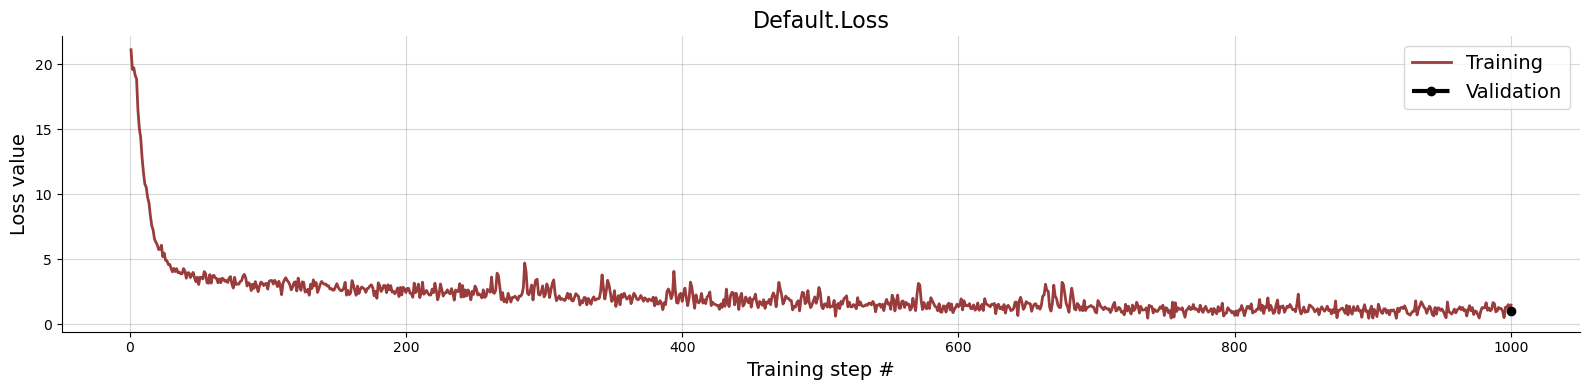

In [25]:
f = bf.diagnostics.plot_losses(h['train_losses'], h['val_losses'])

# Validation Phase
## Inspecting the Latent Space

In [26]:
#f = trainer.diagnose_latent2d()

# Simulation-Based Calibration - Rank Histograms

In [27]:
num_test = 1000
num_posterior_draws_recovery = 5000
#num_posterior_draws_cal = 400
new_sims = configurator(generative_model(num_test))

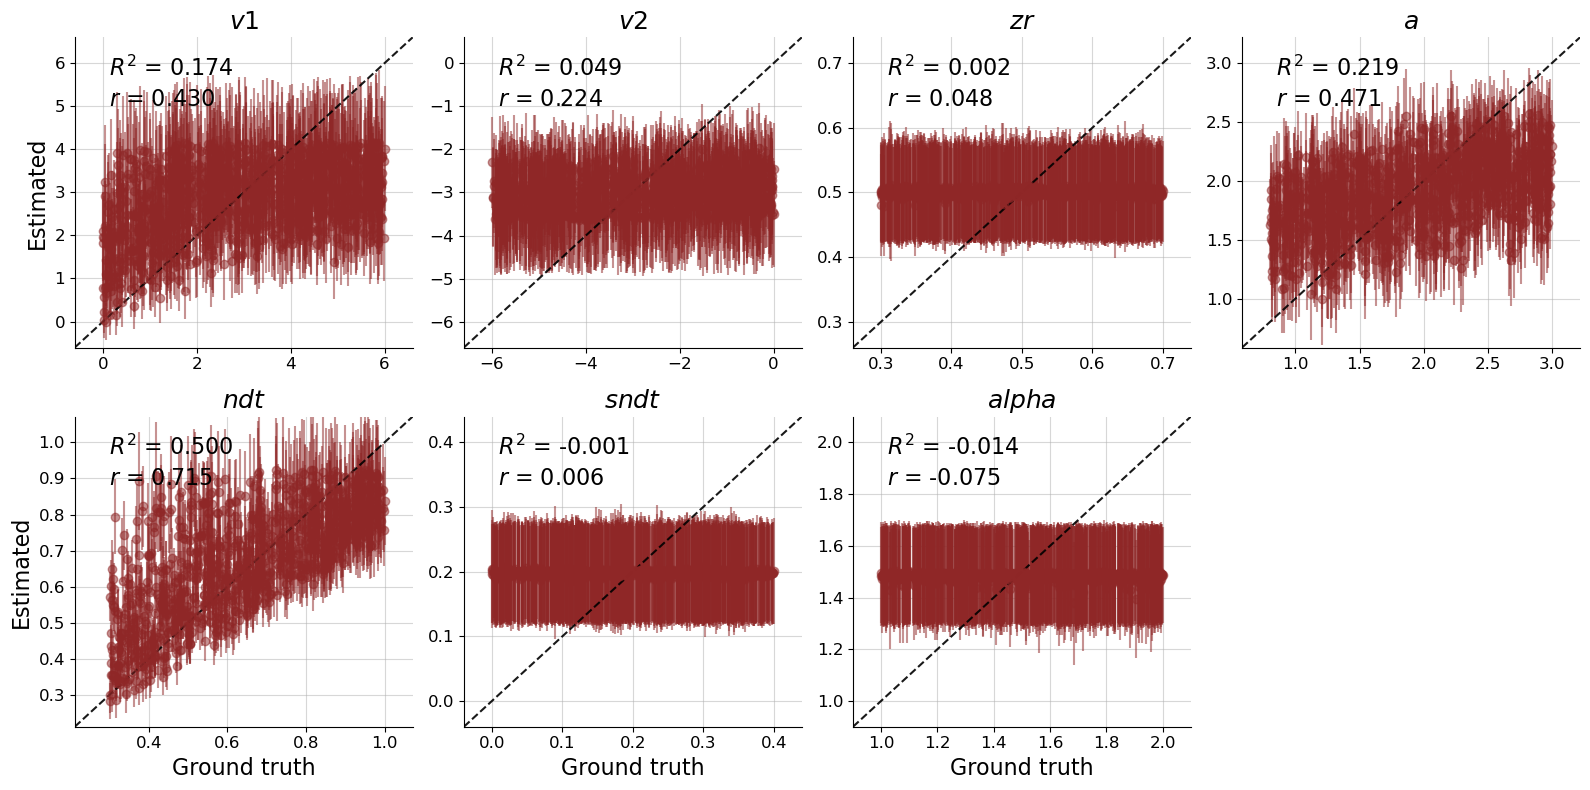

In [31]:
posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
fig = bf.diagnostics.plot_recovery(posterior_draws, new_sims['parameters'],param_names = param_names)

IndexError: unsupported iterator index

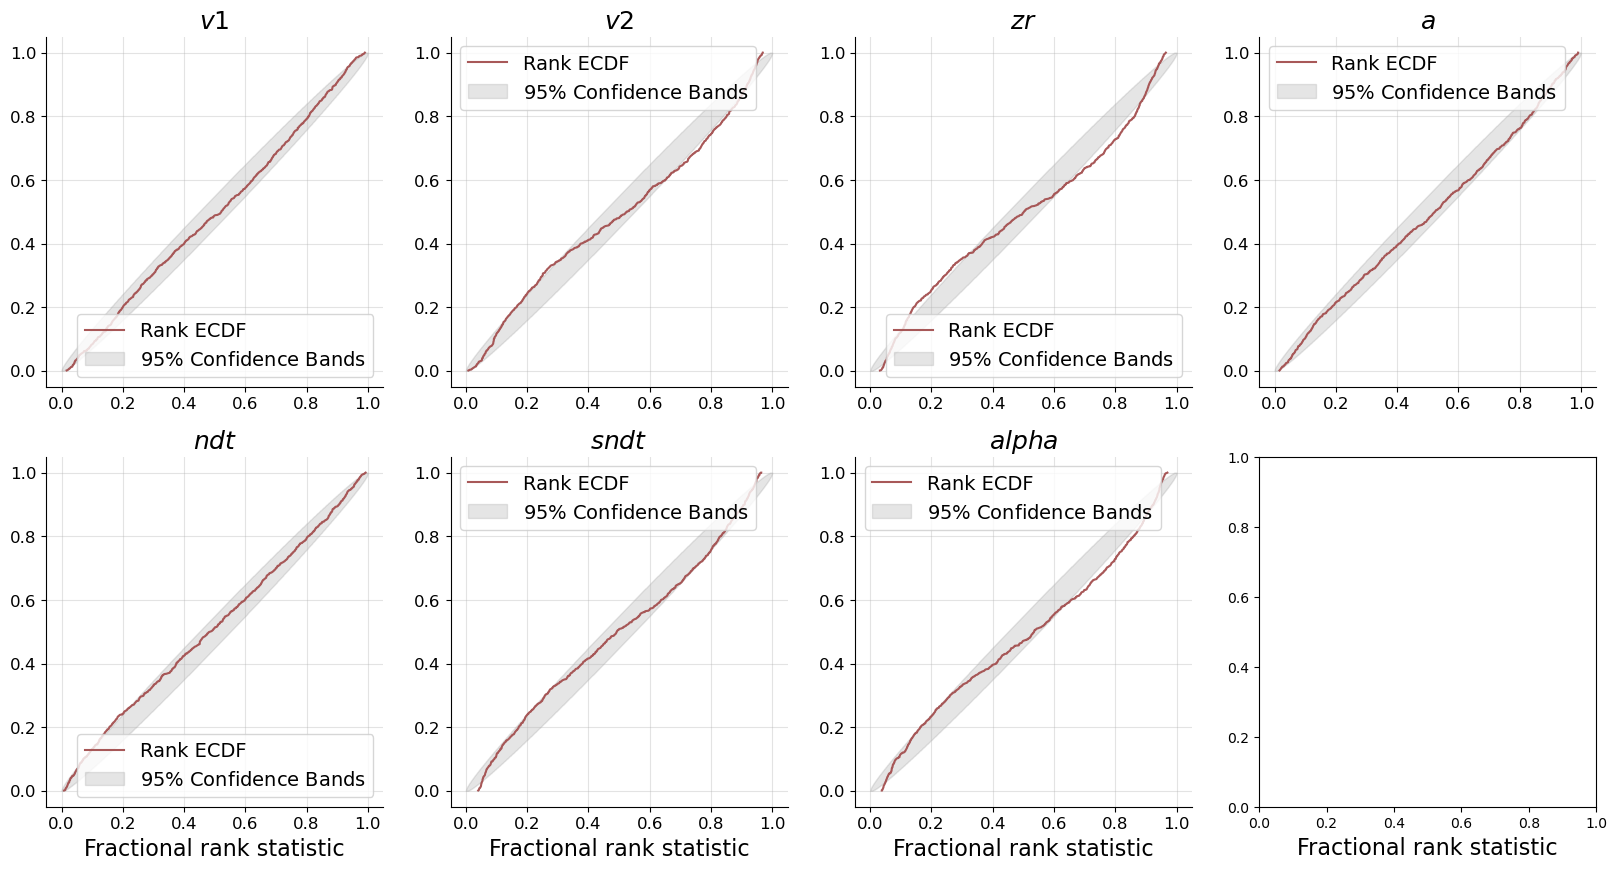

In [32]:
#posterior_draws = amortizer.sample(new_sims, n_samples=100)
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'],param_names = param_names)

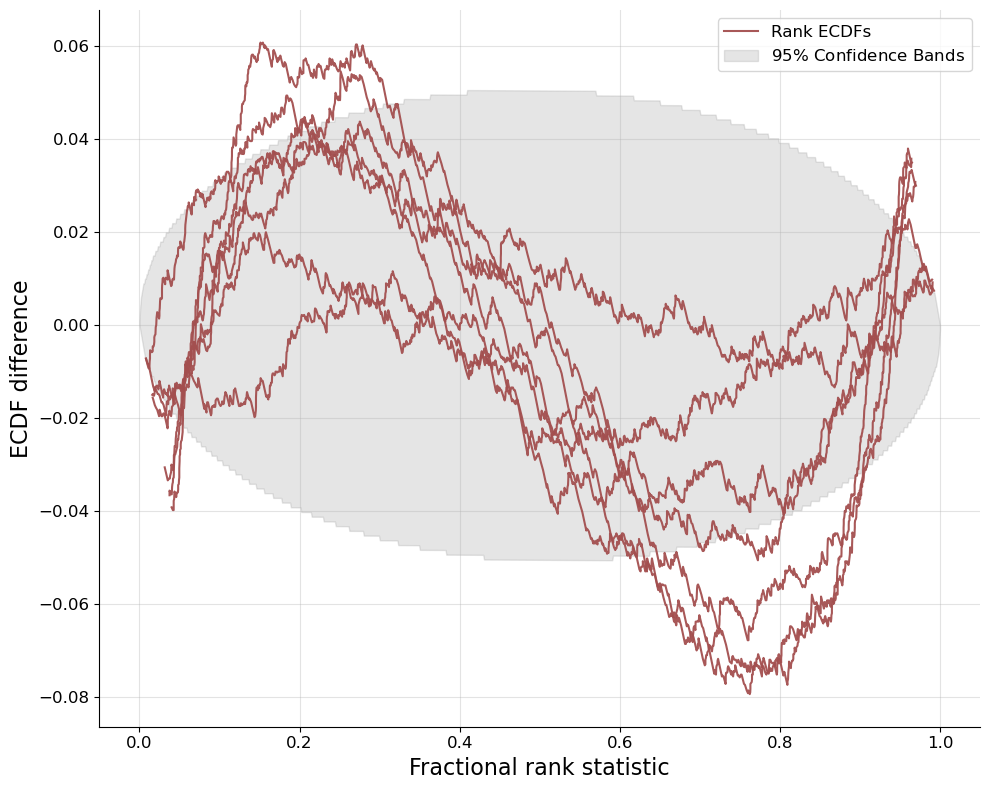

In [33]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'], stacked=True, 
                       difference=True, legend_fontsize=12, fig_size=(10, 8),param_names = param_names)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


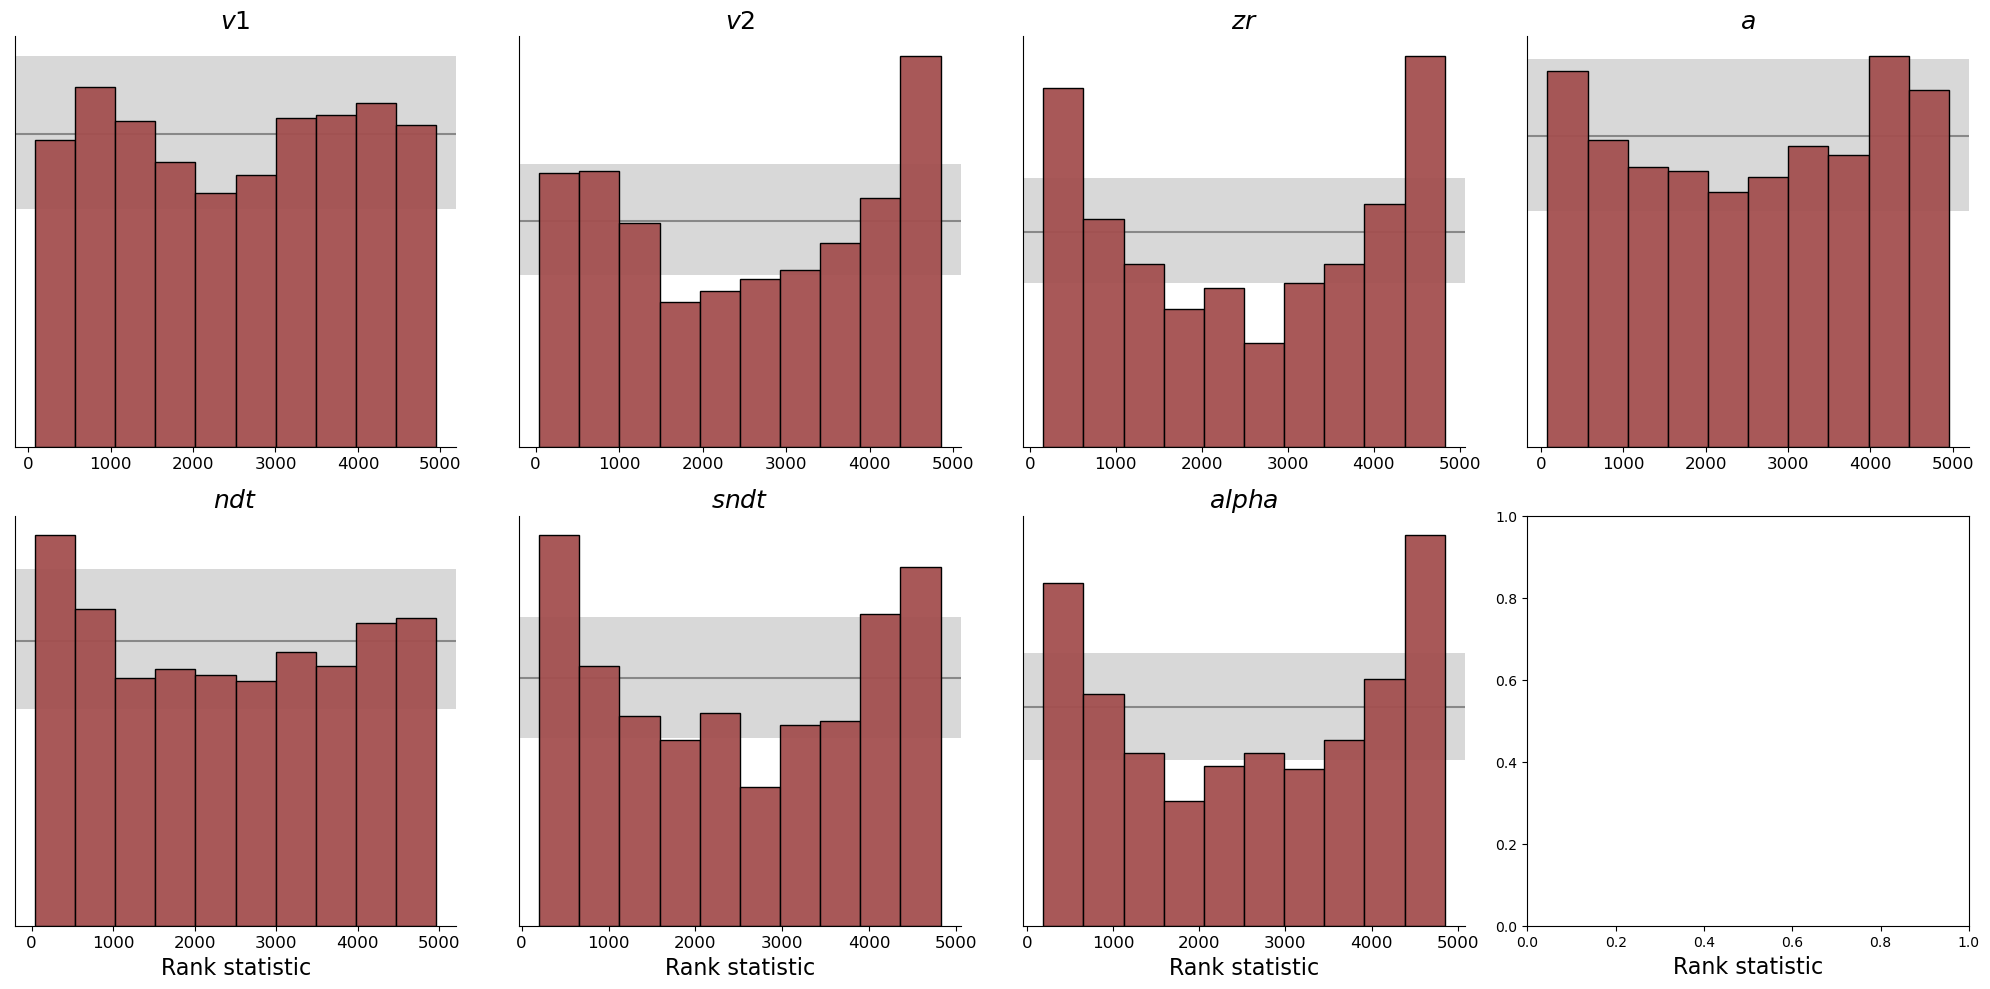

In [34]:
#posterior_draws = amortizer.sample(new_sims, n_samples=50)
f = bf.diagnostics.plot_sbc_histograms(posterior_draws, new_sims['parameters'], num_bins=10,param_names = param_names)

In [ ]:
#posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
# Michael Nunez's recovery function
def recovery(possamps, truevals):  # Parameter recovery plots
    """Plots true parameters versus 99% and 95% credible intervals of recovered
    parameters. Also plotted are the median (circles) and mean (stars) of the posterior
    distributions.

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is the
    number of chains, the second to last dimension is the number of samples in
    each chain, all other dimensions must match the dimensions of truevals

    truevals : ndarray of true parameter values
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))
    truevals = np.reshape(truevals, (nvars))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    for v in range(0, nvars):
        # Compute percentiles
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Plot credible intervals
            credint = np.ones(100) * truevals[v]
            y = np.linspace(bounds[b], bounds[-1 - b], 100)
            lines = plt.plot(credint, y)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark median
                mmedian = plt.plot(truevals[v], np.median(alldata[v, :]), 'o')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(truevals[v], np.mean(alldata[v, :]), '*')
                plt.setp(mmean, markersize=10, color=teal)
    # Plot line y = x
    tempx = np.linspace(np.min(truevals), np.max(
        truevals), num=100)
    recoverline = plt.plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color=orange)


# Plot the results
fig=plt.figure(figsize=(15,8), tight_layout=True)

columns = 3
rows = 2
param_names = [r'$v$, Drift Rate', r'$zr$, Boundary', r'$a$, Relative Start Point', r'$ndt$, Non-Decision Time',r'$alpha$, alpha stable']
for i in range(5):
    
    fig.add_subplot(rows, columns, i+1)
    recovery(posterior_draws[:, :, i].reshape(num_test, num_posterior_draws_recovery, 1), new_sims['parameters'][:, i].squeeze())
    plt.xlabel('Grand truth', fontsize=16)
    plt.ylabel('Posterior', fontsize=16)
    plt.title(param_names[i], fontsize=16)
    if i==0:
        plt.legend(['99% CI','95% CI','Median', 'Mean'], fontsize=11, loc = 'upper left')




In [21]:
import pandas as pd
df = pd.read_csv('./SF1.txt', sep=" ")
df.head()

,pp,block,trl_number,cat_correct,resp,acc,RT
0,1000,practice,0,1,1,1,4258
1,1000,practice,0,2,2,1,3410
2,1000,practice,0,2,2,1,5064
3,1000,practice,0,1,1,1,3332
4,1000,test,0,1,1,1,3698


In [22]:
#filtering the practice trials
df = df.loc[df['block'] == 'test']
np.shape(df)

(12625, 7)

In [23]:
#converting false RT to negative and turn it to seconds 
df_n = df.loc[(df['acc'] == 0)] 
df_n.loc[:, 'RT'] *= -1/1000
#df_n['RT'] = df_n['RT'].apply(lambda x: x*-1)
df_p = df.loc[(df['acc'] == 1)] 
df_p.loc[:, 'RT'] *= 1/1000

ready_data=pd.concat([df_p, df_n])
ready_data

/tmp/ipykernel_593199/1520292462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n.loc[:, 'RT'] *= -1/1000
/tmp/ipykernel_593199/1520292462.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p.loc[:, 'RT'] *= 1/1000


,pp,block,trl_number,cat_correct,resp,acc,RT
4,1000,test,0,1,1,1,3.698
6,1000,test,2,1,1,1,4.038
7,1000,test,3,2,2,1,7.879
8,1000,test,4,1,1,1,4.280
9,1000,test,5,1,1,1,6.581
...,...,...,...,...,...,...,...
12988,5022,test,69,1,2,0,-1.455
12999,5022,test,80,1,2,0,-2.032
13016,5022,test,97,2,1,0,-1.369
13055,5023,test,31,2,1,0,-2.272


In [24]:
#data with participant (125 pp then 125 data set with 101 trial)
UniqueNames = ready_data.pp.unique()
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = ready_data[:][ready_data.pp == key]

In [25]:
RT_sets = []
for i in DataFrameDict.keys():
    RT_sets.append(np.array(DataFrameDict[i]['RT']))
RT_sets = np.array(RT_sets)    
print(np.shape(RT_sets))
type(RT_sets)


(125, 101)


numpy.ndarray

In [26]:
out_Real={}
N = np.log( RT_sets.shape[1])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
N_vec = N * np.ones((RT_sets.shape[0], 1), dtype=np.float32)
#out={'summary_conditions':}


out_Real['direct_conditions'] = N_vec
out_Real['summary_conditions'] = RT_sets.reshape( RT_sets.shape[0], RT_sets.shape[1],1)
#out_Real['summary_conditions'] = RT_sets.astype(np.float32)
#out_Real
   

In [27]:
posterior_draws = amortizer.sample(out_Real,n_samples=1000)
#posterior_draws
post_samples = prior_means + posterior_draws * prior_stds

#print(post_samples)
post_samples.shape



(125, 1000, 5)

(array([  5.,  16.,  84., 185., 266., 235., 144.,  52.,  11.,   2.]),
 array([-0.12288775, -0.06647534, -0.01006292,  0.0463495 ,  0.10276192,
         0.15917433,  0.21558675,  0.27199917,  0.32841159,  0.384824  ,
         0.44123642]),
 <BarContainer object of 10 artists>)

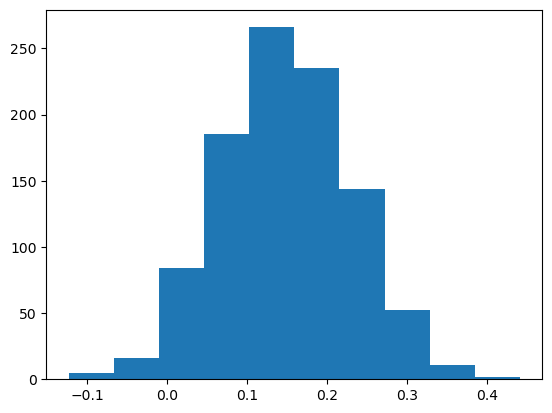

In [28]:
post_samples_v_p = post_samples[0,:,0]
plt.hist(post_samples_v_p)

In [29]:
single_pp = post_samples[0,:,:]

0.3738014885266667

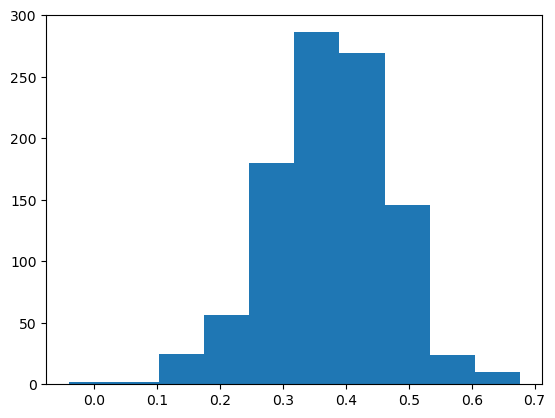

In [33]:
single_param= single_pp[:,1]
plt.hist(single_param)
np.mean(single_param)

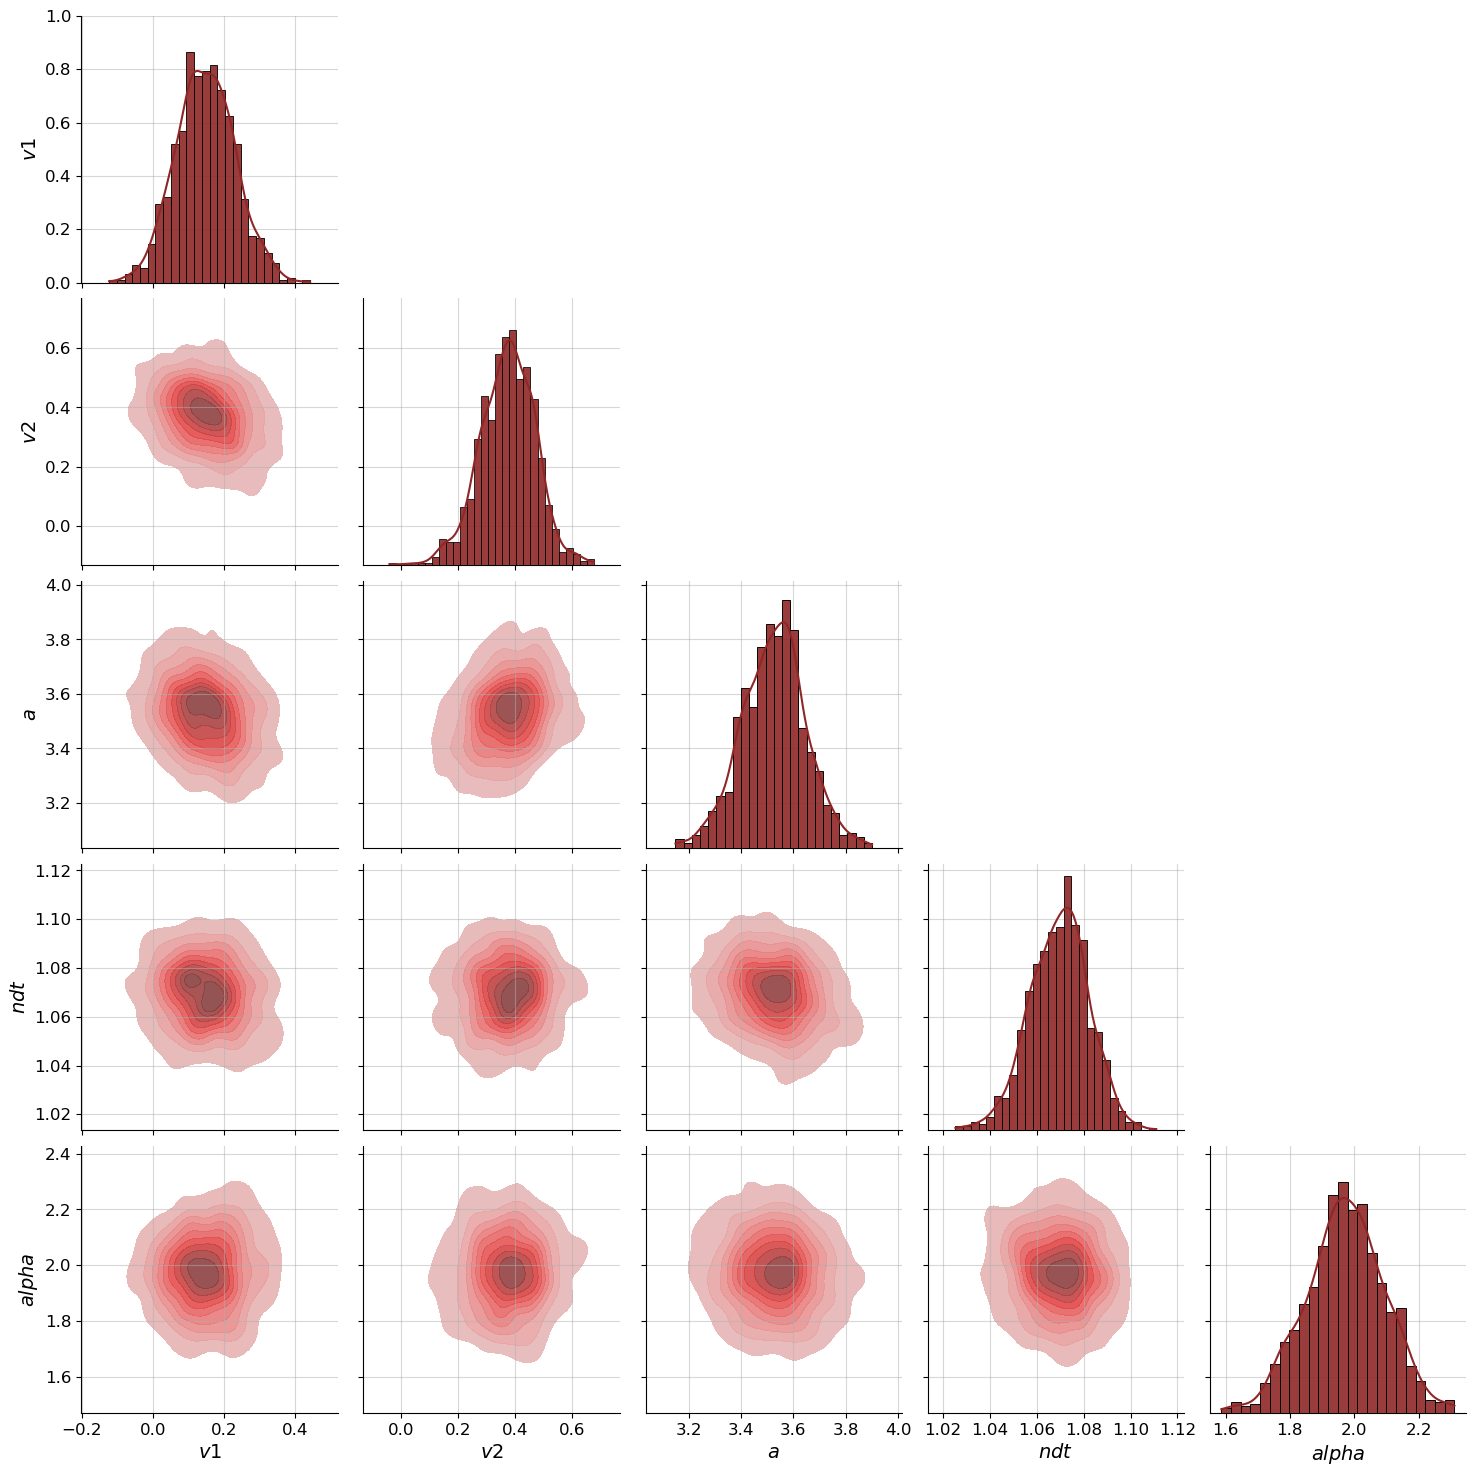

In [30]:
f = bf.diagnostics.plot_posterior_2d(single_pp,param_names=prior.param_names)

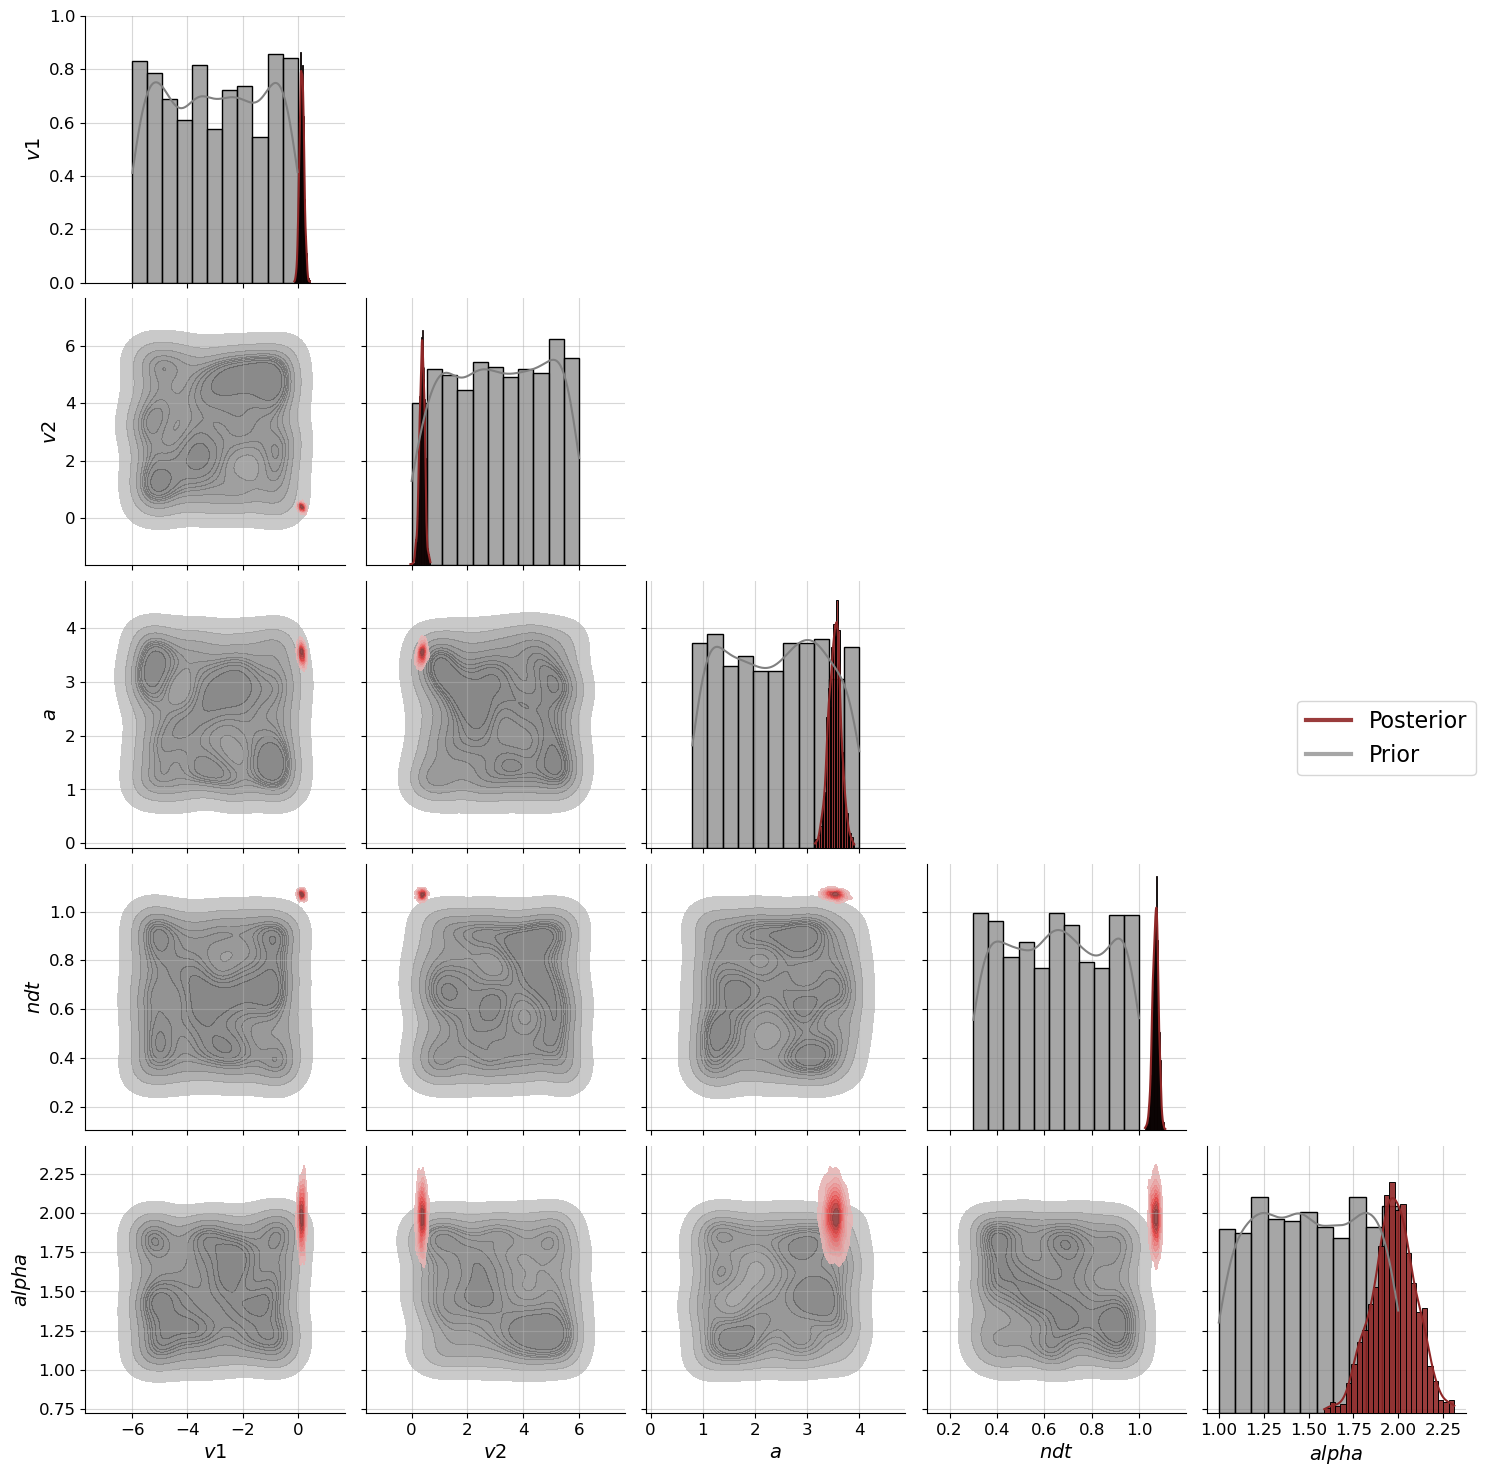

In [31]:
f = bf.diagnostics.plot_posterior_2d(single_pp, prior=prior)

In [37]:
import matplotlib.pyplot as plt

def plot_ppc(config, post_samples, logscale=True, color='Blue', 
                            dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_cases = stationary_SIR(samples[i], config['N'], config['T'])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)
    
    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label='Median predicted cases', color=color)
    ax.plot(config['obs_data'], marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
    
    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config['T']), qs_50[0], qs_50[1], color=color, alpha=0.3, label='50% CI')
    ax.fill_between(range(config['T']), qs_90[0], qs_90[1], color=color, alpha=0.2, label='90% CI')
    ax.fill_between(range(config['T']), qs_95[0], qs_95[1], color=color, alpha=0.1, label='95% CI')
    
    # Grid and schmuck
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days since pandemic onset')
    ax.set_ylabel('Number of cases')
    ax.minorticks_off()
    if logscale:
        ax.set_yscale('log')
    ax.legend(fontsize=font_size)
    return f

In [ ]:
f = plot_ppc(config, post_samples)
